<a href="https://colab.research.google.com/github/giacomogreggio/HSL-citybikes-predictor/blob/master/HSL_citybikes_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Citybike predictor

### Elevator pitch
Scheduling your day is important for everyone, but every day we have to face problems related to planning your itinerary. When you want to use a citybike to move from a place to another you may find yourself at an empty bike station. Could there be a way to predict the availability? A solution: an application that predicts exactly that based on the time and the weather.


### Data: sources, wrangling, management		
- The original purpose of the data is not compatible with our needs: the data is meant to describe bike trips/routing, not the bike availability
- 
            
### Data analysis: statistics, machine learning	
- We need a predicting model
- Predictions for time series: a lot of different variables
- Combining different data sources to base the prediction to current situation: weather, time of the day, current bike availability    


### Communication of results: summarization & visualization
- Finding clear and intuitive way to summarize and visualize data such that it is accessible to the user
- 
            
### Operationalization: creating added value, end-user point of view
- Mobile optimated web application

## Preprocessing the HSL-data

### Initializing everything

In [ ]:
!pip install mpld3

     |████████████████████████████████| 1.0MB 4.3MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.1-cp36-none-any.whl size=364064 sha256=da812d38df810354c39110c04446ee56ce9afb536586ed4c46ab96b5498fa54d
  Stored in directory: /root/.cache/pip/wheels/38/68/06/d119af6c3f9a2d1e123c1f72d276576b457131b3a7bf94e402
Successfully built mpld3


In [ ]:
# All imports

import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime
from pandas.tseries.offsets import MonthEnd
#import mpld3
#from mpld3 import plugins
#mpld3.enable_notebook()
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer
import category_encoders as ce

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


### Data preprocessing functions

In [ ]:
def get_station_data():
  stations = pd.read_csv("/content/drive/My Drive/HSLDataset/Helsingin_ja_Espoon_kaupunkipyöräasemat.csv")
  stations = stations.drop(["FID", "Nimi", "Namn", "Adress", "Kaupunki", "Stad", "Operaattor"], axis = 1)
  return stations

In [ ]:
def rate_weather(row):
    score = 10
    if row['cloud_amount']<2 : score = score
    if row['cloud_amount']<5 and row['cloud_amount']>=2 : score = score-1
    if row['cloud_amount']<8 and row['cloud_amount']>=5 : score = score-2
    if row['cloud_amount']>=8 : score = score-3
    if row['visibility']>=40000 : score = score
    if row['visibility']>=10000 and row['visibility']<40000 :  score = score-1
    if row['visibility']<10000 :  score = score-2
    if row['rain_intensity']<=0.25 :  score = score
    if row['rain_intensity']<=1 and row['rain_intensity']>0.25: score = score-1   
    if row['rain_intensity']<=4 and row['rain_intensity']>1: score = score-2
    if row['rain_intensity']<=16 and row['rain_intensity']>4: score = score-3
    if row['rain_intensity']>16: score = score-4   
    if row['wind_speed']<=1.5: score = score   
    if row['wind_speed']<=3.3 and row['wind_speed']>1.5: score = score-1
    if row['wind_speed']<=8 and row['wind_speed']>3.3: score = score-2
    if row['wind_speed']>8: score = score-3
    if score<1 : score = 1
    return(score)

In [ ]:
def get_weather_data():
  filepath ='/content/drive/My Drive/HSLDataset/bikeweather_2019.csv'
  df = pd.read_csv(filepath)
  df = df.rename(
      columns={
      'Vuosi': 'year', 'Kk': 'month', 'Pv': 'day', 'Klo': 'time', 'Aikavyöhyke': 'timezone', 'Pilvien määrä (1/8)': 'cloud_amount',
      'Ilmanpaine (msl) (hPa)': 'pressure', 'Suhteellinen kosteus (%)': 'rel_humidity', 'Sateen intensiteetti (mm/h)': 'rain_intensity',
      'Lumensyvyys (cm)': 'snow_depth', 'Ilman lämpötila (degC)': 'air_temp', 'Kastepistelämpötila (degC)': 'dew-point_temp',
      'Näkyvyys (m)': 'visibility', 'Tuulen suunta (deg)': 'wind_dir', 'Puuskanopeus (m/s)': 'gust_speed', 'Tuulen nopeus (m/s)': 'wind_speed'
      }
  )
  df = df.drop(['pressure', 'rel_humidity', 'snow_depth', 'dew-point_temp', 'wind_dir', 'gust_speed'], axis=1)
  df['datetime']=pd.to_datetime(df.year.astype(str)+'-'+df.month.astype(str)+'-'+df.day.astype(str)+' '+df.time.astype(str))
  df['weather_rate'] = df.apply(lambda row: rate_weather(row), axis=1)
  return df  

In [ ]:
def preprocess_month(month):
  path = "/content/drive/My Drive/HSLDataset/od-trips-2019/"
  extension = ".csv"
  filename = "2019-" + '{:02.0f}'.format(month)
  full_path = path + filename + extension
  
  data = pd.read_csv(full_path, sep = ",")

  # Make time a datetime object to ease handling. Also floor to starting hour
  data["Dep date"] = pd.to_datetime(data["Departure"], errors = "ignore").dt.floor(freq = "H")
  data["Return date"] = pd.to_datetime(data["Return"], errors = "ignore").dt.floor(freq = "H")

  # For our analysis we shouldn't need this information
  data = data.drop(columns=["Covered distance (m)", "Duration (sec.)", "Departure", "Return"])

  # Get the outgoing bikes per station at timeframe
  outgoing = data.groupby("Departure station id")["Dep date"].value_counts()
  outgoing = outgoing.sort_index()
  outgoing = outgoing.rename_axis(index = {"Dep date" : "Date", "Departure station id" : "ID"})
  outgoing = outgoing.rename("Outgoing")

  # Get the arriving bikes per station at timeframe
  arriving = data.groupby("Return station id")["Return date"].value_counts()
  arriving = arriving.sort_index()
  arriving = arriving.rename_axis(index = {"Return date" : "Date", "Return station id" : "ID"})
  arriving = arriving.rename("Arriving")

  outgoing_arriving_merge = pd.merge(outgoing, arriving, on = ["ID", "Date"], how = "outer")
  outgoing_arriving_merge = outgoing_arriving_merge.fillna(0)

  
  stations = set(outgoing_arriving_merge.index.get_level_values(0))

  # We need data for ALL timeframes
  first_day_of_month = "2019-" + '{:02.0f}'.format(month) + "-01 00:00:00"
  last_day_of_month = pd.Timestamp("2019-" + '{:02.0f}'.format(month) + "-01 23:00:00") + MonthEnd(0)
  all_dates = pd.date_range(first_day_of_month, last_day_of_month, freq = "H")
  idx = pd.MultiIndex.from_product([stations, all_dates], names = ["ID", "Date"])
  mega_frame_with_station_date_cartesian_product = pd.DataFrame(index = idx)
  processed = pd.merge(mega_frame_with_station_date_cartesian_product, outgoing_arriving_merge, on = ["ID", "Date"], how = "left")
  processed = processed.fillna(0)
  processed = processed.reset_index()

  # Merge with the station data from HSL
  station_data = get_station_data()
  processed_with_station_data = pd.merge(processed, station_data, on = "ID", how = "inner")

  processed_with_station_data.to_csv("./drive/My Drive/HSLDataset/processed/" + filename + "-processed.csv")

In [ ]:
def process_and_write_raw_data():
  # Process all the data and save them as csv-files
  for month in range(4,11):
    data = preprocess_month(month)

#### Merging functions

In [ ]:
def drop_columns_weather(df):
  return df.drop(columns=['year','month','day','time','timezone','cloud_amount','rain_intensity','air_temp','visibility','wind_speed'])

In [ ]:
def drop_columns_bikes(df):
  bikes = df.drop(columns=['Osoite','Kapasiteet','x','y'])
  bikes = bikes.rename(columns={'Date':'datetime', 'Outgoing':'departures', 'Arriving':'arrivals','ID':'station_id','Name':'station_name'})
  return bikes

In [ ]:
# Merging on datetime column: the column must be named 'datetime' in both tables
def merge_tables(df1, df2):
  merged = df1.merge(
    df2,
    how='inner',
    on='datetime'
  )
  return merged

#### Getters for data

In [ ]:
def get_processed_data_for_month(month):
  month = '{:02.0f}'.format(month)
  data = pd.read_csv("/content/drive/My Drive/HSLDataset/processed/2019-" + month + "-processed.csv")
  data["Date"] = pd.to_datetime(data["Date"])
  
  # Don't know what this is all about but I guess everything is fine-ish :DDD
  data = data.drop("Unnamed: 0", axis = 1)

  data["weekday"] = data["Date"].dt.weekday
  data["hour"] = data["Date"].dt.hour
  data["month"] = data["Date"].dt.month
  return data

In [ ]:
def merge_all_data_and_write():
  # Get the already processed data for all the months
  data_april = get_processed_data_for_month(4)
  data_may = get_processed_data_for_month(5)
  data_june = get_processed_data_for_month(6)
  data_july = get_processed_data_for_month(7)
  data_august = get_processed_data_for_month(8)
  data_september = get_processed_data_for_month(9)
  data_october = get_processed_data_for_month(10)

  # Concatanate the trip count data of the months
  big_boi = pd.concat([data_april, data_may, data_june, data_july, data_august, data_september, data_october])

  # Merge the weather data
  weather_data = get_weather_data()
  merged_megaset = merge_tables(drop_columns_bikes(big_boi),drop_columns_weather(weather_data))

  merged_megaset.to_csv("./drive/My Drive/HSLDataset/processed/whole_data-processed.csv", index = False)
  return merged_megaset

In [ ]:
def get_all_data():
  data = pd.read_csv("./drive/My Drive/HSLDataset/processed/whole_data-processed.csv")
  data["datetime"] = pd.to_datetime(data["datetime"])
  data["hour"] = data["datetime"].dt.hour
  data["month"] = data["datetime"].dt.month
  return data

## Looking at the data

### Quick init

In [ ]:
# All imports

import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from datetime import datetime
from pandas.tseries.offsets import MonthEnd
#import mpld3
#from mpld3 import plugins
#mpld3.enable_notebook()
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer
import category_encoders as ce

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def get_all_data():
  data = pd.read_csv("./drive/My Drive/HSLDataset/processed/whole_data-processed.csv")
  data["datetime"] = pd.to_datetime(data["datetime"])
  data["hour"] = data["datetime"].dt.hour
  data["month"] = data["datetime"].dt.month
  return data
all_data = get_all_data()

### Getter functions for specific subsets of data

In [ ]:
def data_of_station_for_weekdays_in_month(dataframe, station, month, weekday):
  station_data = dataframe[dataframe["station_id"] == station]
  station_data_for_month = station_data[(station_data["datetime"].dt.month == month) & (station_data["datetime"].dt.weekday == weekday)]
  return station_data_for_month

### Test area

In [ ]:
all_data = get_all_data()

In [ ]:
# Useful for picking a station by name: some hot stations are most of the ones at a metro station (M) and ones near the central railway
stations = get_station_data()

NameError: ignored

## Different data visualizations

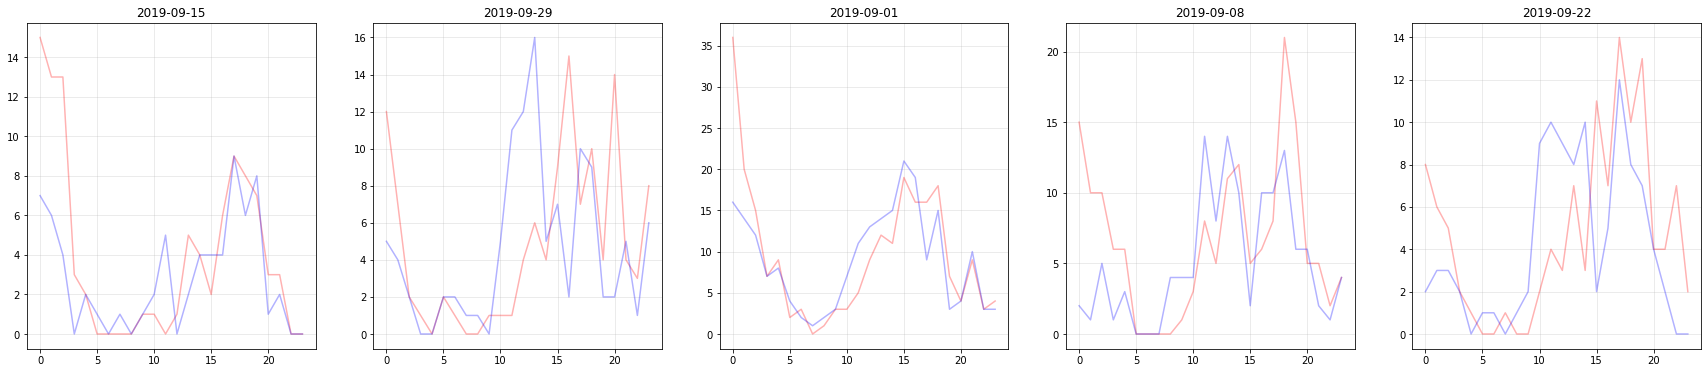

In [ ]:
wanted_data = data_of_station_for_weekdays_in_month(all_data, 19, 9, 6)
weekday_occurences = set(wanted_data["datetime"].dt.date)
fig, axs = plt.subplots(1, len(weekday_occurences), figsize = (30,6))


for idx,weekday_occurence in enumerate(weekday_occurences):
  weekday_occurence_data = wanted_data[wanted_data["datetime"].dt.date == weekday_occurence]
  axs[idx].grid(True, alpha = 0.3)
  axs[idx].plot(weekday_occurence_data["datetime"].dt.hour, weekday_occurence_data["departures"], 'r', weekday_occurence_data["datetime"].dt.hour, weekday_occurence_data["arrivals"], 'b', alpha = 0.3)
  axs[idx].title.set_text(weekday_occurence)
plt.show()

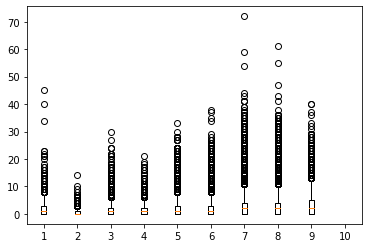

In [ ]:
subset = all_data[(all_data["datetime"].dt.hour == 14)]

for rating in range(1,11):
  rating_subset = subset[subset["weather_rate"] == rating]
  plt.boxplot(rating_subset["departures"], positions=[rating])
plt.show()

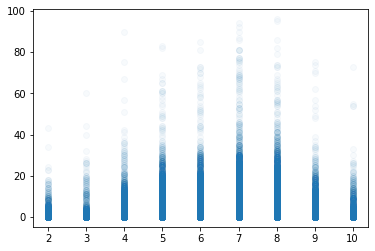

In [ ]:
subset = all_data[(all_data["datetime"].dt.hour == 8)]
plt.scatter(subset["weather_rate"], subset["departures"], alpha = 0.03)

## Machine learning stuff

In [ ]:
# One-hot encoding for hours months and weekdays
hour_dummies = pd.get_dummies(all_data.loc[:, "hour"], prefix="hour")
month_dummies = pd.get_dummies(all_data.loc[:, "month"], prefix="month")
weekday_dummies = pd.get_dummies(all_data.loc[:, "weekday"], prefix="weekday")

In [ ]:
station_dummies = pd.get_dummies(all_data.loc[:, "station_id"], prefix="station")
X = pd.concat([station_dummies, hour_dummies, month_dummies, weekday_dummies], axis = 1)
X["weather_rate"] = all_data.loc[:,"weather_rate"]
y = all_data.loc[:,"departures"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.4)

In [ ]:
# Do the ML

rfst = RandomForestClassifier(n_estimators = 10).fit(X_train, y_train)
y_predicted = rfst.predict(X_test)
accuracy_score(y_test, y_predicted)

0.46320330040202023